In [1]:
import pandas as pd
import numpy as np
from anytree import RenderTree #used only to have a visual of what the tree looks like
import math

In [2]:
def entropy_calculation(array, total):
    """
    This method returns the entropy calculation.
    
    """
    entropy = 0

    for i in array:
        entropy += (-i/total) * math.log((i/total),2)
        
    return entropy

In [3]:
def weighted_entropy(entropies, split_total, total):
    """
    This method returns the weighted entropy calculation.
    
    """
    index = 0
    w_entropy = 0
    
    for i in split_total:
        w_entropy += (i/total) * entropies[index]
        index += 1
        
    return w_entropy

In [4]:
def Importance_Helper(attributes): 
    """
    This method returns the different answers for each attribute. 
    Example: if a certain attributes has 'cloudy', 'cloudy', 'cloudy', 'cloudy', 'rainy', it should return 
    'cloudy', 'rainy'
    
    """
    temp = set(attributes) #This method works, make sure to pass through a data frame and a specific column
   
    return temp

In [5]:
def Importance_Counter(attributes, distinct_attributes): 
    """
    This method should count how many times an attribute occured. For example, if we have 
    'rainy', 'rainy', 'rainy', 'cloudy' and 'rainy', 'cloudy'
    it should return 3 1
    """
    count = [] #Creates new list that will contain the counted values
    distinct_attributes = distinct_attributes.to_numpy() #Convert the selected column to numpy array for easier counting
    
    for i in attributes: #Go through numpy array
        
        counter = (distinct_attributes == i).sum() #Count how many of i are in a specified column         
        count.append(counter) #Add the count of i to the count list
        
    return count

In [6]:
def Importance(dataframe):
    """
    This method returns the best attribute to split a dataframe by.
    
    """
    row = len(dataframe.columns) - 1
    total_items = len(dataframe.index) #gets the total number of rows in dataframe which happens to be the number of items total
    values = Importance_Helper(dataframe.iloc[:,-1])
    vc_total = list(values) #get the values of the class column
   
    icount_total = Importance_Counter(vc_total, dataframe.iloc[:,-1]) #get the count of each value in the class column
   
    parent_entropy = entropy_calculation(icount_total, total_items) #get the parent entropy
    best_attribute = None
    best_info_gain = 0

    for rn in range(row):
        entropies = [] #create an array for entropies in the current rn
        temp = dataframe.iloc[:,rn]

        values = Importance_Helper(temp)
        vc_test = list(values) #get values of the current column

        icount = Importance_Counter(vc_test, temp) #get the count of each value in the current column

        index = 0 #used for entropy

        for i in vc_test: #use the values for splitting
            split = dataframe[dataframe[dataframe.columns[rn]].str.contains(i)] #split the rows by values

            temp = split.iloc[:,-1] #get the class column
            values = Importance_Helper(temp)
            vc_test = list(values) #get values of the class column

            icount2 = Importance_Counter(vc_test, temp) #get the total number of each value
            
            entropy = entropy_calculation(icount2, icount[index]) #calculate entropy
           
            entropies.append(entropy) #add calculated entropy to entropies array
            index += 1

        wentropy = weighted_entropy(entropies, icount, total_items) #get the weighted entropy of all splits

        info_gain = parent_entropy - wentropy #get the information gain

        if info_gain > best_info_gain: #check if current info gain is better
            best_info_gain = info_gain #assign new info gain
            best_attribute = dataframe.columns[rn] #assign the attribute that produced the best info gain

    return best_attribute #return best attribute to use for splitting

In [7]:
def split_by_attribute(dataframe, attribute):
    """
    This method separates a dataframe by a specified attribute. It then returns an array
    containing the separated dataframes and a list of the values of the current attribute.
    
    """
    dataframes = [] #array to store new dataframes
    attribute_values = Importance_Helper(dataframe[attribute]) #find the values of the specified column
    current_values = list(attribute_values) #creates list of current values
    for value in attribute_values: #divide dataframe
        tempDF = dataframe.groupby(attribute).get_group(value) #group rows by specified value
        dataframes.append(tempDF) #add newly separated dataframe to array
        
    return dataframes, current_values #return array containing separated dataframes by value and a list of current values

In [8]:
def assign_class_value(dataframe):
    """
    This method returns the value of the class column of the dataframe. Used to assign the
    class value to a leaf node
    
    """
    class_value = Importance_Helper(dataframe.iloc[:,-1])
    value = list(class_value)
    return value[0]

In [9]:
class BT_Node:
    
    def __init__(self, data): #Constructor
        self.data = data
        self.parent = None
        self.importance = None
        self.value = None
        self.class_value = None
        self.children = [] #May have more than two children
        
    def add_child(self, node):
        node.parent = self #assign parent
        self.children.append(node) #add child to children array

In [10]:
def Build_Decision_Tree(dataframe):
    """
    This method builds the decision. It assumes that the last column in the dataframe is the
    class column. If it is not then the user must rearrange the columns so that the class
    column is at the end. Also for now the user must manually change any column that contains
    booleans to strings by using:
    dataframe_name['column_name'] = dataframe_name['column_name'].map({True: 'True', False: 'False'})
    
    """
    split = Importance(dataframe) #first find the best attribute to split by
    index = 0 #used to assign values to nodes
    if split != None: 
        root = BT_Node(dataframe) #create node
        root.importance = split #assign the importance to the node
        splited_dfs, current_values = split_by_attribute(dataframe, split) #separate the dataframe by attribute chosen and get a
                                                                           #list of the current values
    
        for df in splited_dfs: #go through array of dataframes 
            node = Build_Decision_Tree(df) #recurssively build tree
            node.value = current_values[index] #assign value to node
            root.add_child(node) #node becomes a child of root
            index += 1
            
        return root
    else: #if split is None then the current dataframe is a leaf
        root = BT_Node(dataframe) #create node
        root.importance = 'leaf'
        root.class_value = assign_class_value(dataframe)
        return root

In [11]:
def Check_Boolean(dataframe, current_values, column_name):
    for i in current_values:
        if i == True:
            dataframe[column_name] = dataframe[column_name].map({True: 'True', False: 'False'})

In [12]:
df = pd.read_csv("loandata.csv")
df['Has_Job'] = df['Has_Job'].map({True: 'True', False: 'False'})
df['Own_House'] = df['Own_House'].map({True: 'True', False: 'False'})
#test_node = Build_Decision_Tree(df)
#print(RenderTree(test_node))
df

,Age,Has_Job,Own_House,Credit_Rating,Class
0,young,False,False,fair,No
1,young,False,False,good,No
2,young,True,False,good,Yes
3,young,True,True,fair,Yes
4,young,False,False,fair,No
5,middle,False,False,fair,No
6,middle,False,False,good,No
7,middle,True,True,good,Yes
8,middle,False,True,excellent,Yes
9,middle,False,True,excellent,Yes


In [13]:
#Used to see how the program finds the best attribute to split by

row = len(df.columns) - 1
total_items = len(df.index) #gets the total number of rows in dataframe which happens to be the number of items total
values = Importance_Helper(df.iloc[:,-1])
vc_total = list(values) #get the values of the class column
print('parent class values are:')
print(vc_total)
icount_total = Importance_Counter(vc_total, df.iloc[:,-1]) #get the count of each value in the class column
print('parent class values counts are:')
print(icount_total)
parent_entropy = entropy_calculation(icount_total, total_items) #get the parent entropy
print('parent entropy is: {}'.format(parent_entropy))
best_info_gain = 0

print('-------------------------------------------------------------------------')

for rn in range(row):
    entropies = [] #create an array for entropies in the current rn
    temp = df.iloc[:,rn]
    #print(temp)
    values = Importance_Helper(temp)
    vc_test = list(values)
    print('{} column values are:'.format(df.columns[rn]))
    print(vc_test)
    icount = Importance_Counter(vc_test, temp)
    print('{} column values counts are:'.format(df.columns[rn]))
    print(icount)
    index = 0 #used for entropy
    print('-----------------------------------------------------')
    
    print('Split by {}:'.format(df.columns[rn]))
    print('-----------------------------------------------------')
    
    #Check_Boolean(df, vc_test, df.columns[rn])
    
    
    for i in vc_test: #use the labels for splitting
        
        
        
        split = df[df[df.columns[rn]].str.contains(i)] #split the rows by values
        print(split)
        temp = split.iloc[:,-1]
        values = Importance_Helper(temp) #get the labels of the values
        vc_test = list(values)
        print('class values are:')
        print(vc_test)
        icount2 = Importance_Counter(vc_test, temp) #get the total number of each value
        print('class values counts are:')
        print(icount2)
        entropy = entropy_calculation(icount2, icount[index]) #calculate entropy
        print('entropy = {}'.format(entropy))
        entropies.append(entropy) #add calculated entropy to entropies array
        index += 1
        print('-----------------------------------------------------')
        
    print('Entropies for {} are:'.format(df.columns[rn]))
    print(entropies)
    wentropy = weighted_entropy(entropies, icount, total_items) #get the weighted entropy of all splits
    print('weighted entropy = {}'.format(wentropy))
    
    info_gain = parent_entropy - wentropy #get the information gain
    print('informatio gain = {}'.format(info_gain))
    
    print('-------------------------------------------------------------------------')
    
    if info_gain > best_info_gain:
        best_info_gain = info_gain
        best_attribute = df.columns[rn]
    
        
print('the best info gain is: {}'.format(best_info_gain))
print('best attribute to split by is: {}'.format(best_attribute))

parent class values are:
['Yes', 'No']
parent class values counts are:
[9, 6]
parent entropy is: 0.9709505944546686
-------------------------------------------------------------------------
Age column values are:
['young', 'old', 'middle']
Age column values counts are:
[5, 5, 5]
-----------------------------------------------------
Split by Age:
-----------------------------------------------------
     Age Has_Job Own_House Credit_Rating Class
0  young   False     False          fair    No
1  young   False     False          good    No
2  young    True     False          good   Yes
3  young    True      True          fair   Yes
4  young   False     False          fair    No
class values are:
['Yes', 'No']
class values counts are:
[2, 3]
entropy = 0.9709505944546686
-----------------------------------------------------
    Age Has_Job Own_House Credit_Rating Class
10  old   False      True     excellent   Yes
11  old   False      True          good   Yes
12  old    True     False      

In [14]:
import matplotlib.pyplot as plt

In [15]:
from sklearn import tree

In [16]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [17]:
data = pd.read_csv('loandata.csv')

In [18]:
data.head()

,Age,Has_Job,Own_House,Credit_Rating,Class
0,young,False,False,fair,No
1,young,False,False,good,No
2,young,True,False,good,Yes
3,young,True,True,fair,Yes
4,young,False,False,fair,No


In [19]:
data.iloc[:,0] = np.unique(data["Age"], return_inverse=True)[1].tolist()

In [20]:
data.iloc[:,1] = np.unique(data["Has_Job"], return_inverse=True)[1].tolist()

In [21]:
data.iloc[:,2] = np.unique(data["Own_House"], return_inverse=True)[1].tolist()

In [22]:
data.iloc[:,3] = np.unique(data["Credit_Rating"], return_inverse=True)[1].tolist()

In [23]:
data.iloc[:,4] = np.unique(data["Class"], return_inverse=True)[1].tolist()

In [24]:
data.head()

,Age,Has_Job,Own_House,Credit_Rating,Class
0,2,0,0,1,0
1,2,0,0,2,0
2,2,1,0,2,1
3,2,1,1,1,1
4,2,0,0,1,0


In [25]:
clf.fit(data.iloc[:,:4],data.iloc[:,4])

DecisionTreeClassifier(criterion='entropy')

In [26]:
clf.predict(data.iloc[:,:4])

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

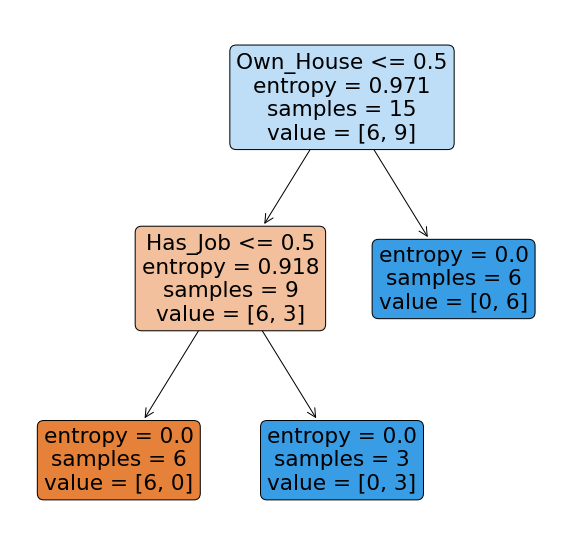

In [27]:
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(clf, 
                   feature_names=
                   ["Age","Has_Job","Own_House","Credit_Rating"],  
                   #class_names=['yes'],
                   filled=True,rounded=True)

In [28]:
fig.savefig('DT.png')

# Build Decison Tree

$Entropy(D) = -(9/15)*log_2(9/15)-(6/15)*log_2(6/15) = 0.9709$

***Attribute: Age***

|D1          | D2        |D3         |
-------------|-----------|-----------| 
|Young : 5   |Middle: 5  |Old: 5     |
|Y : 2  N : 3|Y : 3 N : 2|Y : 4 N : 1|

$Entropy(D1) = -(2/5)*log_2(2/5)-(3/5)*log_2(3/5) = 0.9709$